# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
 
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 44kB/s  eta 0:00:01 0% |                                | 30kB 1.9MB/s eta 0:00:08    18% |█████▉                          | 2.7MB 13.4MB/s eta 0:00:01█████████████████████▌          | 9.8MB 45.6MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

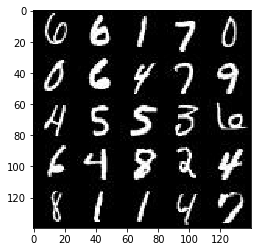

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

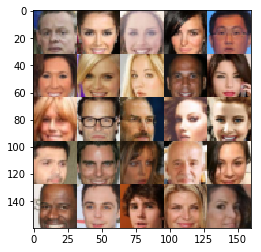

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 32, 32, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### resetting TF graph 

In [5]:
tf.reset_default_graph()

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real =tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='latent_vector') 
    learn_rate = tf.placeholder(tf.float32, [])
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


##### implementing leaky relu for general usage

In [7]:
def lrelu(bn, alpha=0.1):
    return tf.maximum(alpha * bn, bn)

### log control

In [8]:
logger_on = True
def log(str):
    if logger_on:
        print(str)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
logger_on = False

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = lrelu(bn1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        do3 = tf.nn.dropout(x3, 0.8)
        bn3 = tf.layers.batch_normalization(do3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x512

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits
   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
alpha = 0.2

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = lrelu(x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = lrelu(x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = lrelu(x3)
        # 28x28x128 now
        
        # Output layer
        out = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', activation=tf.tanh)
        # 28x28x3 now
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smoothness = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-label_smoothness)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
        
        print('end of training')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 1.4449
Epoch 1/2... Discriminator Loss: 2.4422... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 3.4438... Generator Loss: 0.1023
Epoch 1/2... Discriminator Loss: 2.6441... Generator Loss: 0.1658
Epoch 1/2... Discriminator Loss: 2.5221... Generator Loss: 0.1798
Epoch 1/2... Discriminator Loss: 2.0752... Generator Loss: 0.2466
Epoch 1/2... Discriminator Loss: 2.0556... Generator Loss: 0.2337
Epoch 1/2... Discriminator Loss: 2.0819... Generator Loss: 0.2639
Epoch 1/2... Discriminator Loss: 1.9577... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 0.2087


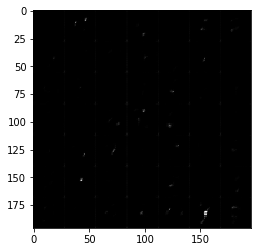

Epoch 1/2... Discriminator Loss: 1.6811... Generator Loss: 0.3928
Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.3361
Epoch 1/2... Discriminator Loss: 1.8023... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 1.9417... Generator Loss: 0.2723
Epoch 1/2... Discriminator Loss: 1.8103... Generator Loss: 0.3053
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.3176
Epoch 1/2... Discriminator Loss: 1.9994... Generator Loss: 0.2633
Epoch 1/2... Discriminator Loss: 1.8654... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 1.7762... Generator Loss: 0.3453
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.5720


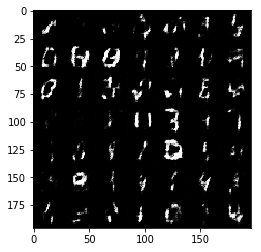

Epoch 1/2... Discriminator Loss: 1.5885... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 1.9647... Generator Loss: 0.2729
Epoch 1/2... Discriminator Loss: 1.6934... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.2479
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 0.3970
Epoch 1/2... Discriminator Loss: 1.6535... Generator Loss: 0.4094
Epoch 1/2... Discriminator Loss: 1.8104... Generator Loss: 0.3455
Epoch 1/2... Discriminator Loss: 1.7744... Generator Loss: 0.3088
Epoch 1/2... Discriminator Loss: 1.6982... Generator Loss: 0.3621


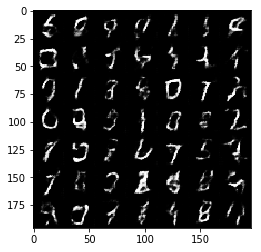

Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.3727
Epoch 1/2... Discriminator Loss: 1.8585... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 1.7784... Generator Loss: 1.6698
Epoch 1/2... Discriminator Loss: 1.4876... Generator Loss: 1.2473
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 1.1701
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 1.5452
Epoch 1/2... Discriminator Loss: 1.6985... Generator Loss: 1.4628
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 1.3059
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 1.1828


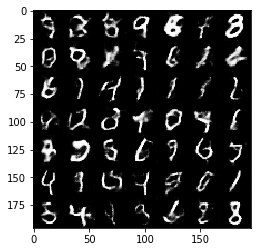

Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 1.3006
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.6619... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.7549... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.4008
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 1.5962... Generator Loss: 0.4160


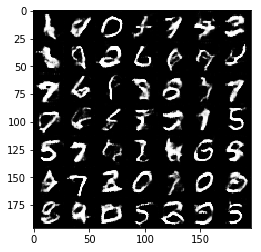

Epoch 1/2... Discriminator Loss: 1.6635... Generator Loss: 0.3959
Epoch 1/2... Discriminator Loss: 1.6467... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 1.7123... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.4342
Epoch 1/2... Discriminator Loss: 1.5533... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.4789
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.5714
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.5222


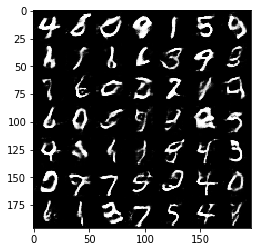

Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.4780
Epoch 1/2... Discriminator Loss: 1.6592... Generator Loss: 0.3469
Epoch 1/2... Discriminator Loss: 1.7347... Generator Loss: 0.3354
Epoch 1/2... Discriminator Loss: 1.6353... Generator Loss: 0.4114
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 1.3555
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 2.0796... Generator Loss: 0.2584
Epoch 1/2... Discriminator Loss: 1.6170... Generator Loss: 0.3970


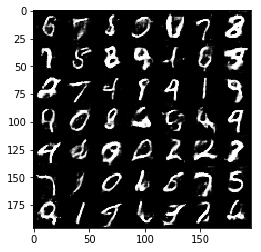

Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.4514
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.3810
Epoch 1/2... Discriminator Loss: 1.8025... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 2.0986... Generator Loss: 0.2408
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 1.3229
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 1.8535


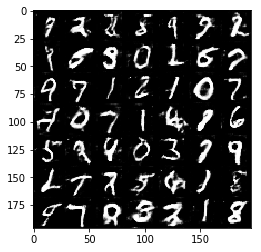

Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.8600... Generator Loss: 0.3127
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.5607
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.5048
Epoch 1/2... Discriminator Loss: 1.8401... Generator Loss: 0.3462


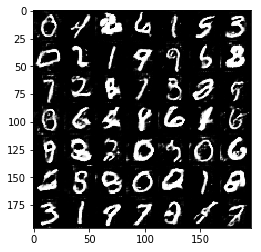

Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 1.7349
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.5656
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.7089... Generator Loss: 0.3386
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.4289
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.5259
Epoch 2/2... Discriminator Loss: 1.5134... Generator Loss: 0.4819


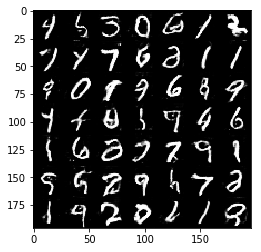

Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.8689... Generator Loss: 0.2675
Epoch 2/2... Discriminator Loss: 1.7023... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.6948... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.4662
Epoch 2/2... Discriminator Loss: 1.7404... Generator Loss: 1.9397
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 1.8251


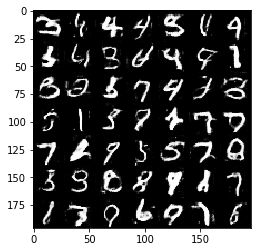

Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 1.8378
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.6011
Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.3870
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.6491... Generator Loss: 0.3833
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 1.8659
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 1.2070


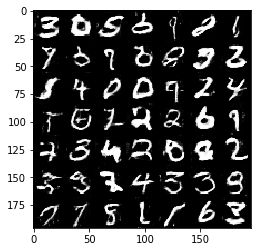

Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 1.5630
Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 2.2021
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.9611
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 1.6257
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 1.4974
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.5300
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.8534


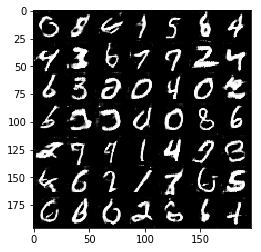

Epoch 2/2... Discriminator Loss: 1.5700... Generator Loss: 0.5080
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 1.4501
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 1.8322
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 1.7944
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 1.3750
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0910
Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 1.2296


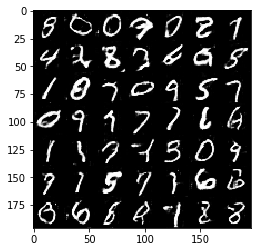

Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 0.3846
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.4559
Epoch 2/2... Discriminator Loss: 1.6613... Generator Loss: 0.3808
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.6012
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 1.0702
Epoch 2/2... Discriminator Loss: 1.5902... Generator Loss: 0.4243
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.7080


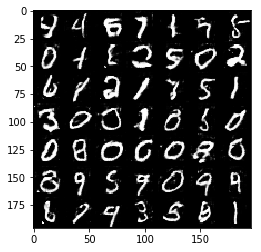

Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 2.2049
Epoch 2/2... Discriminator Loss: 1.8466... Generator Loss: 2.3661
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 1.7220... Generator Loss: 2.5578
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 1.9299
Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 1.2032
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 2.7545
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.1839


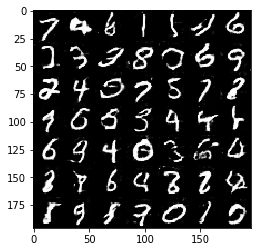

Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.4882... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.5895
Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.1036... Generator Loss: 1.7887
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.2306


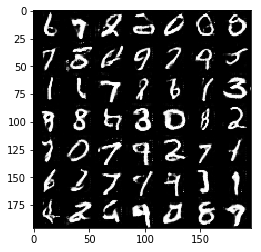

Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.5063
Epoch 2/2... Discriminator Loss: 0.7644... Generator Loss: 1.8917
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 1.8866
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 2.0546
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 2.1214
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.5796


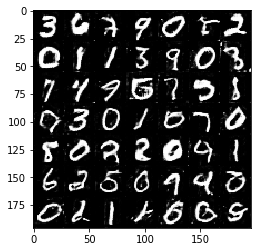

Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 4.2561
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.8000
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 2.3813
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.6087
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 1.7956
end of training


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1

logger_on = False

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
""" 
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7359... Generator Loss: 19.1798
Epoch 1/1... Discriminator Loss: 3.1814... Generator Loss: 12.7053
Epoch 1/1... Discriminator Loss: 2.2856... Generator Loss: 3.8806
Epoch 1/1... Discriminator Loss: 2.4463... Generator Loss: 3.8207
Epoch 1/1... Discriminator Loss: 1.8812... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 2.5601... Generator Loss: 4.1272
Epoch 1/1... Discriminator Loss: 2.1449... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.7902


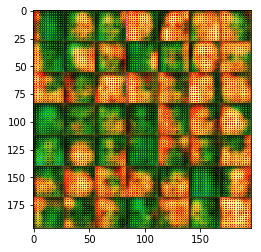

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 2.6931
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 3.6778... Generator Loss: 3.5228
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 1.7953... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 2.0064... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 1.9046... Generator Loss: 1.9768
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.9597


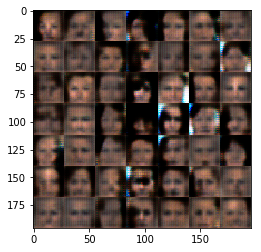

Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 2.4100... Generator Loss: 2.0016
Epoch 1/1... Discriminator Loss: 2.2996... Generator Loss: 2.3776
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.7804... Generator Loss: 0.3788


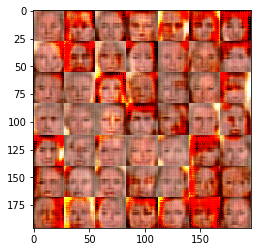

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5211


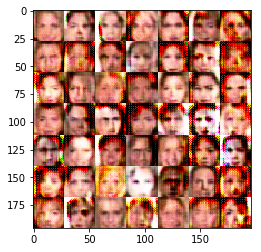

Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.7471... Generator Loss: 0.5225


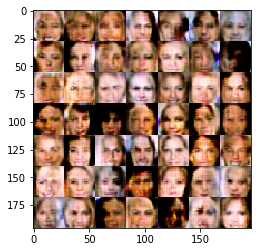

Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 2.2234... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6851


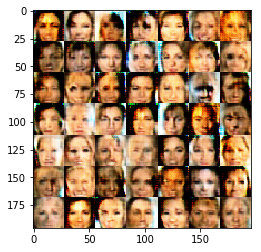

Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.6921... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8607


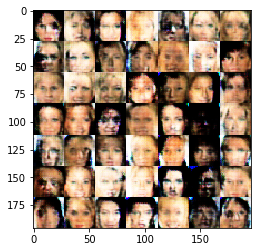

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.9005


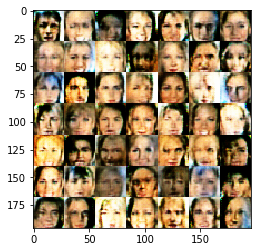

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7940


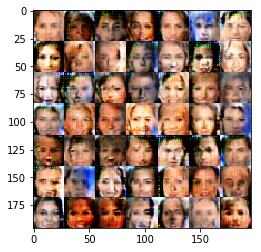

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.4926


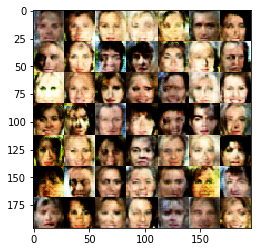

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7117


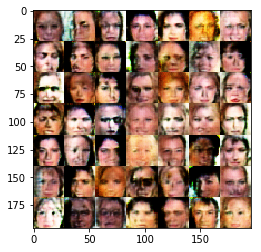

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6974


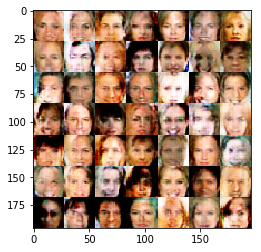

Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.0161


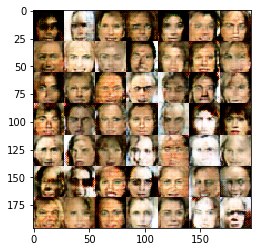

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6767


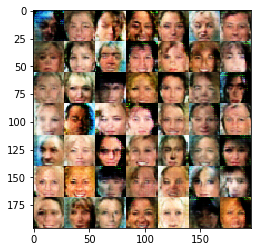

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6587


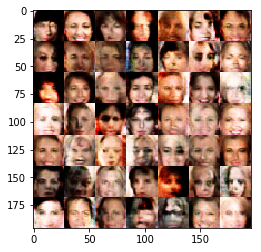

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.9163


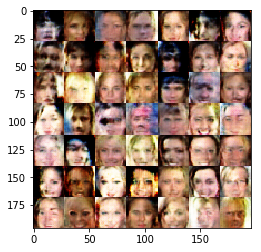

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6612


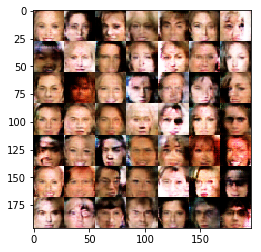

Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 1.0884


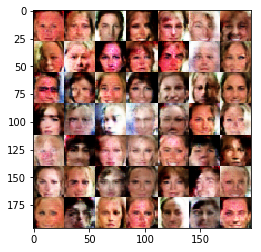

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6545


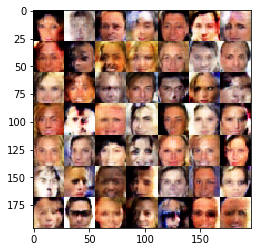

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5999


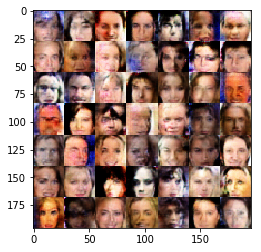

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7991


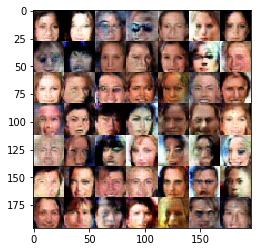

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7266


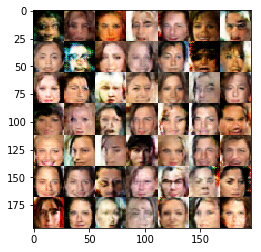

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6978


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1

logger_on = False


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.